In [1]:
import re
import numpy as np
import spacy
from tqdm import tqdm
import tensorflow as tf
import pandas as pd
import seaborn as sns
import time
import tarfile
import matplotlib.pyplot as plt
import itertools
import os
from scipy import stats, integrate
import seaborn as sns
import random
import urllib.request
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=1)
from HanSequenceLabellingModel import HanSequenceLabellingModel
%load_ext autoreload
%autoreload 1
%aimport HanSequenceLabellingModel, model_components
%aimport
%matplotlib inline

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Modules to reload:
HanSequenceLabellingModel model_components

Modules to skip:



In [2]:
class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data


example = next(iter(ImdbMovieReviews()))
type(example[0]), type(example[0][0]), type(example[1])

(list, str, bool)

In [3]:
class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = spacy.load('en_vectors_web_lg')
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [4]:
def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [ ]:
!!python3 -m spacy download en_vectors_web_lg

In [5]:
reviews = list(ImdbMovieReviews())

In [6]:
random.shuffle(reviews)

In [7]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=10)

In [8]:
#################################################

In [9]:
def HAN_model_1(session, restore_only=False, attention=True):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
            attention=attention
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

In [11]:
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, _) in enumerate(batches_split):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        t0 = time.clock()
        step, summaries, loss, accuracy, _ = s.run([
                model.global_step,
                model.summary,
                model.loss,
                model.accuracy,
                model.train_op,
        ], feed_dict=fd)
        td = time.clock() - t0

        summary_writer.add_summary(summaries, global_step=step)

        checkpoint_frequency = 100
        eval_frequency = 1
        
        if step % 1 == 0:
            print('step %s, loss=%s, accuracy=%s, t=%s, inputs=%s' % (step, loss, accuracy, round(td, 2), 
                                                                      fd[model.inputs_embedded].shape))
        if step != 0 and step % checkpoint_frequency == 0:
            print('checkpoint & graph meta')
            checkpoint_path = 'checkpoints/checkpoint'
            saver.save(s, checkpoint_path, global_step=step)
            print('checkpoint done')
        if step % 2 == 0:
            break

Reading model parameters from checkpoints/checkpoint-2600
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2600
step 2601, loss=0.243285, accuracy=0.9, t=95.38, inputs=(10, 41, 126, 300)
step 2602, loss=0.149402, accuracy=0.9, t=24.09, inputs=(10, 20, 72, 300)


## Visualize attention for IMDB reviews

In [112]:
from __future__ import print_function
from colour import Color
red = Color("red")
colors_sent = list(red.range_to(Color("green"), 1024))
colors_val = list(red.range_to(Color("blue"),1024))

In [113]:
from colors import Color

In [ ]:
from IPython.core.display import display, HTML

In [124]:
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch = next(batches_split)
    fd = {model.is_training: True, model.inputs_embedded: data, 
          model.word_lengths: words_per_sent_per_doc,
          model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
          model.sample_weights: np.ones(shape=(10))}
    sent_attentionsatts, word_attentions = s.run([model.sentence_attentions, model.word_attentions], feed_dict=fd)
    
    
    sent_attentions = np.squeeze(sent_attentions[0, :len(sents)])  
    word_attentions = np.squeeze(word_attentions[:len(sents), :])  
    sents = sents_batch[0]  
    html = ''
    nsents, max_len = len(sents), max(sum(map(len, sent)) + max(map(len, sent)) - 1 for sent in sents)
    if max_width is not None: max_len = min(max_len, max_width)
    for i, sent in tqdm(enumerate(sents)):
        visualization += '<div>'
        sent_alpha = sent_attentionsatts[i]
        visualization += '<span style="background: rgba(0, 0, 0, {})">&nbsp;&nbsp;&nbsp;&nbsp;</span>'.format(sent_alpha)
        for j, word in enumerate(sent):
            word_alpha = word_attentions[i, j]
            a = 255 * word_alpha
            visualization += '<span style="background: rgba(0, 0, 0, {})">{} </span>'.format(word_alpha, word)
        visualization += '</div>'


Reading model parameters from checkpoints/checkpoint-2600
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2600


In [133]:
HTML(visualization1)

## Plot attention weight distribution of words "good" and "bad"

In [31]:
iters = 200
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
good_pos = []
good_neg = []
bad_pos = []
bad_neg = []
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_b) in tqdm(enumerate(batches_split)):
        fd = {
              model.is_training: True, model.inputs_embedded: data, 
              model.word_lengths: words_per_sent_per_doc,
              model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
              model.sample_weights: np.ones(shape=(10))
        }
        sent_attentions, word_attentionsatts = s.run([model.sentence_attentions, model.word_attentions], feed_dict=fd)
        length = 0
        for i, sents in enumerate(sents_b):
            for j, sent in enumerate(sents):
                for k, word in enumerate(sent):
                    if word == 'good':
                        if labels_batch[i] == 1:
                            good_pos.append(word_attentions[length + j, k])
                        else:
                            good_neg.append(word_attentions[length + j, k])
                    if word == 'bad':
                        if labels_batch[i] == 1:
                            bad_neg.append(word_attentions[length + j, k])
                        else:
                            bad_pos.append(word_attentions[length + j, k])
            length += len(sents) + 1
        if i == iters:
            break
good_pos = np.array(good_pos)
good_neg = np.array(good_neg)
bad_pos = np.array(bad_pos)
bad_neg = np.array(bad_neg)

Reading model parameters from checkpoints/checkpoint-2600
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2600


200it [19:21,  5.81s/it]

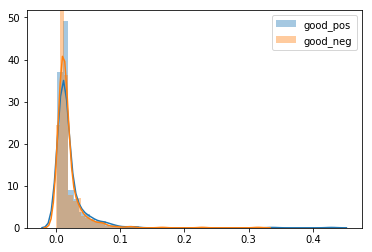

In [60]:
sns.distplot(good_pos,  label='good_pos')
sns.distplot(good_neg,  label='good_neg')
plt.legend()

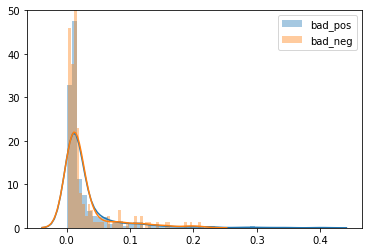

In [61]:
sns.distplot(bad_pos,  label='bad_pos')
sns.distplot(bad_neg,  label='bad_neg')
plt.legend()

## Compare accuracy for HAN with plain rnn-based model and singe-word-attention model 

In [15]:
iters = 200
tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True)
with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s, True)
    cum = 0.
    cum_correct = 0
    for i, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in tqdm(enumerate(batches_split)):
        fd = {model.is_training: False, model.inputs_embedded: data, 
              model.word_lengths: words_per_sent_per_doc,
              model.sentence_lengths: sent_per_doc, model.labels: labels_batch, 
              model.sample_weights: np.ones(shape=(10))}
        label_predict = s.run(model.prediction, feed_dict=fd)
        cum_correct += np.sum(labels_batch == label_predict)
        cum += len(labels_batch)
        if i % 40 == 0:
            print('acc=', cum_correct / cum)
        if i == iters:
            break

Reading model parameters from checkpoints/checkpoint-2600
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2600



0it [00:00, ?it/s]
1it [00:04,  4.17s/it]

0 accuracy= 0.7



Exception in thread Thread-6:
Traceback (most recent call last):
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

31it [02:58,  5.76s/it]

30 accuracy= 0.8354838709677419


61it [05:52,  5.78s/it]

60 accuracy= 0.8311475409836065


91it [08:39,  5.71s/it]

90 accuracy= 0.8362637362637363


121it [10:54,  5.41s/it]

120 accuracy= 0.8429752066115702


151it [13:26,  5.34s/it]

150 accuracy= 0.8450331125827815


181it [15:39,  5.19s/it]

180 accuracy= 0.8425414364640884


200it [16:57,  5.09s/it]
